<a href="https://colab.research.google.com/github/AYA0HASSAN/Pose_detection/blob/Aya_branch/Deal_With_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import scipy.io as sio
import os
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import mlflow
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from mlflow.tracking import MlflowClient
from sklearn.linear_model import ElasticNet

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# import tensorflow_datasets.public_api as tfds

See what .mat format holds , Data Type , and more Info.

In [ ]:
mat = sio.loadmat('C:/Users/Aya Hassan/Supervised ML/Project/AFLW2000-3D/AFLW2000/image00004.mat') 
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Mar 29 22:50:26 2016',
 '__version__': '1.0',
 '__globals__': [],
 'pt2d': array([[ -1.        ,  -1.        ,  -1.        , 231.86956522,
         247.52173913, 263.17391304,  -1.        ,  -1.        ,
          -1.        , 235.7826087 , 247.52173913, 259.26086957,
          -1.        ,  -1.        , 184.91304348, 220.13043478,
         333.60869565,  -1.        , 196.65217391, 227.95652174,
         196.65217391],
        [452.        , 452.        , 452.        , 208.39130435,
         200.56521739, 200.56521739, 452.        , 452.        ,
         452.        , 227.95652174, 224.04347826, 224.04347826,
         452.        , 452.        , 263.17391304, 271.        ,
         286.65217391, 452.        , 302.30434783, 306.2173913 ,
         345.34782609]]),
 'Illum_Para': array([[ 0.84391612,  0.77328593,  0.85474807,  0.59758723,  0.65790999,
          0.53089464,  0.29654956,  1.75613928,  0.        , 20. 

In [ ]:
print("Type of Mat :{}".format(type(mat)))
print("Length of Mat : {}".format(len(mat)))
print("Keys of Mat : {}".format(mat.keys()))


Type of Mat :<class 'dict'>
Length of Mat : 12
Keys of Mat : dict_keys(['__header__', '__version__', '__globals__', 'pt2d', 'Illum_Para', 'Color_Para', 'Tex_Para', 'Shape_Para', 'Exp_Para', 'Pose_Para', 'roi', 'pt3d_68'])


In [ ]:
pt2d = mat['pt2d']
pt2d.shape

(2, 21)

### Read and Handel Data From .mat format into DataFrame

In [ ]:
def _generate_examples(image_dir_path):
    image_files = tf.io.gfile.glob(
        pattern=os.path.join(image_dir_path, "image0*.jpg"))
    label_files = [s.replace("jpg", "mat") for s in image_files]
    for image_file, label_file in zip(image_files, label_files):
      with tf.io.gfile.GFile(label_file, "rb") as f:
        mat = sio.loadmat(f)
      landmarks_68_3d_xyz = mat["pt3d_68"].T.astype(np.float32)
      landmarks_68_3d_xy_normalized = landmarks_68_3d_xyz[..., 0:2] / 450.0
      landmarks_68_3d_z = landmarks_68_3d_xyz[..., 2:]
      labels = mat['Pose_Para'][0]
      yield os.path.basename(image_file),{
          "image": image_file,
          "landmarks_68_3d_xy_normalized": landmarks_68_3d_xy_normalized,
          "landmarks_68_3d_z": landmarks_68_3d_z,
          "labels":labels[:3],
      }

- empty DataFrame to hold the generated data
- col[0]  =  image
- col[1:136] = 68 x_normalized and 68 y_normalized =>Features
- col[137:] = [pitch, yaw, roll] => Labels
- Data Type of 'data' is generator and we will iterate over that genrator to get all data

In [ ]:
# type(data_df) = pd.DataFrame of 140 columns
data_df = pd.DataFrame(columns=np.arange(140))

# type(data) = generator
data = _generate_examples('C:/Users/Aya Hassan/Supervised ML/Project/AFLW2000-3D/AFLW2000')

# save data in data_df
for i in data:
    image,temp = i
    temp = pd.DataFrame(temp.items())
    length = len(data_df)
    data_df.loc[length,0] = image
    data_df.loc[length,1:136] = temp[1][1].flatten()
    data_df.loc[length,137:] = temp[1][3].flatten()

### View Some Information about data_df

In [ ]:
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,image00002.jpg,0.270818,0.371476,0.271928,0.439028,0.281821,0.501044,0.290737,0.557144,0.305607,...,0.71641,0.505972,0.735479,0.474511,0.734893,0.448496,0.722009,-0.399231,0.018227,0.085676
1,image00004.jpg,0.624974,0.589065,0.61631,0.637877,0.610838,0.682343,0.598942,0.720416,0.572863,...,0.673913,0.452317,0.665523,0.442639,0.667997,0.438965,0.671748,0.470065,1.189533,0.300959
2,image00006.jpg,0.5253,0.532627,0.531552,0.576887,0.539036,0.61575,0.542159,0.653784,0.539618,...,0.667754,0.503683,0.674404,0.488047,0.67707,0.478205,0.676958,-0.18465,0.881137,-0.236852
3,image00008.jpg,0.373398,0.570973,0.394883,0.616862,0.423648,0.656644,0.447545,0.692782,0.471016,...,0.666758,0.550021,0.701211,0.532751,0.709997,0.51594,0.712987,-0.175379,0.299208,-0.373374
4,image00010.jpg,0.623249,0.524865,0.638333,0.575779,0.653094,0.621355,0.661199,0.661175,0.65706,...,0.688744,0.469599,0.692353,0.463491,0.695379,0.466536,0.693463,-0.882169,1.198004,-1.033374


In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Columns: 140 entries, 0 to 139
dtypes: object(140)
memory usage: 2.2+ MB


In [ ]:
data_df.to_csv("All_Data.csv")

Convert object data type into numerical for all data

In [ ]:
cols = data_df.columns.drop(0)
data_df[cols] = data_df[cols].apply(pd.to_numeric, errors='coerce')

In [ ]:
data_df.describe()

,1,2,3,4,5,6,7,8,9,10,...,130,131,132,133,134,135,136,137,138,139
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.332708,0.501824,0.338029,0.558674,0.348509,0.610657,0.358886,0.657275,0.373669,0.707680,...,0.685319,0.523560,0.697719,0.504808,0.699773,0.486329,0.697448,-0.107145,0.014077,-0.034479
std,0.132606,0.072270,0.129094,0.068712,0.126460,0.065910,0.122397,0.062874,0.112367,0.057796,...,0.026895,0.035293,0.026064,0.035019,0.026442,0.034718,0.025886,0.628119,0.654185,0.716014
min,-0.144759,0.257162,-0.133382,0.303394,-0.114602,0.346504,-0.090478,0.370328,-0.041378,0.371757,...,0.497078,0.355256,0.548741,0.340225,0.520220,0.329451,0.496090,-12.457202,-6.130066,-16.969362
25%,0.244325,0.459961,0.250195,0.518490,0.259043,0.571933,0.271686,0.620470,0.294279,0.674889,...,0.670886,0.504643,0.682467,0.484877,0.684015,0.466511,0.682769,-0.258503,-0.294246,-0.174806
50%,0.284867,0.501530,0.287525,0.558425,0.302367,0.610733,0.315193,0.656918,0.336316,0.708029,...,0.686338,0.527020,0.699107,0.505133,0.700955,0.483865,0.698821,-0.122268,0.019702,-0.018098
75%,0.380322,0.540811,0.386709,0.595989,0.403067,0.646676,0.414481,0.692186,0.429367,0.740100,...,0.701586,0.544425,0.714830,0.524183,0.716770,0.505297,0.713730,0.040192,0.334715,0.134378
max,0.805921,0.892409,0.810552,0.876123,0.822364,0.858648,0.837042,0.976858,0.829751,1.102729,...,0.874672,0.647413,0.839459,0.645016,0.839978,0.637439,0.833240,15.598820,3.277500,5.829394


### Split data_df into Features and 3 Labels [pitch, yaw, roll]

In [ ]:
# Labels
# [pitch, yaw, roll]
# labels = data_df.loc[:,137:139]*180/np.pi
# pitch = data_df.loc[:,137]*180/np.pi
# yaw = data_df.loc[:,138]*180/np.pi
# roll = data_df.loc[:,139]*180/np.pi
data_df = data_df.sample(frac=1)

labels = data_df.loc[:,137:139]
pitch = data_df.loc[:,137]
yaw = data_df.loc[:,138]
roll = data_df.loc[:,139]

# Features
features = pd.DataFrame(data_df.loc[:,1:136])
features_x = data_df.loc[:,1:68]
features_y = data_df.loc[:,69:136]

array([[<AxesSubplot:title={'center':'69'}>,
        <AxesSubplot:title={'center':'70'}>,
        <AxesSubplot:title={'center':'71'}>,
        <AxesSubplot:title={'center':'72'}>,
        <AxesSubplot:title={'center':'73'}>,
        <AxesSubplot:title={'center':'74'}>,
        <AxesSubplot:title={'center':'75'}>,
        <AxesSubplot:title={'center':'76'}>],
       [<AxesSubplot:title={'center':'77'}>,
        <AxesSubplot:title={'center':'78'}>,
        <AxesSubplot:title={'center':'79'}>,
        <AxesSubplot:title={'center':'80'}>,
        <AxesSubplot:title={'center':'81'}>,
        <AxesSubplot:title={'center':'82'}>,
        <AxesSubplot:title={'center':'83'}>,
        <AxesSubplot:title={'center':'84'}>],
       [<AxesSubplot:title={'center':'85'}>,
        <AxesSubplot:title={'center':'86'}>,
        <AxesSubplot:title={'center':'87'}>,
        <AxesSubplot:title={'center':'88'}>,
        <AxesSubplot:title={'center':'89'}>,
        <AxesSubplot:title={'center':'90'}>,
        

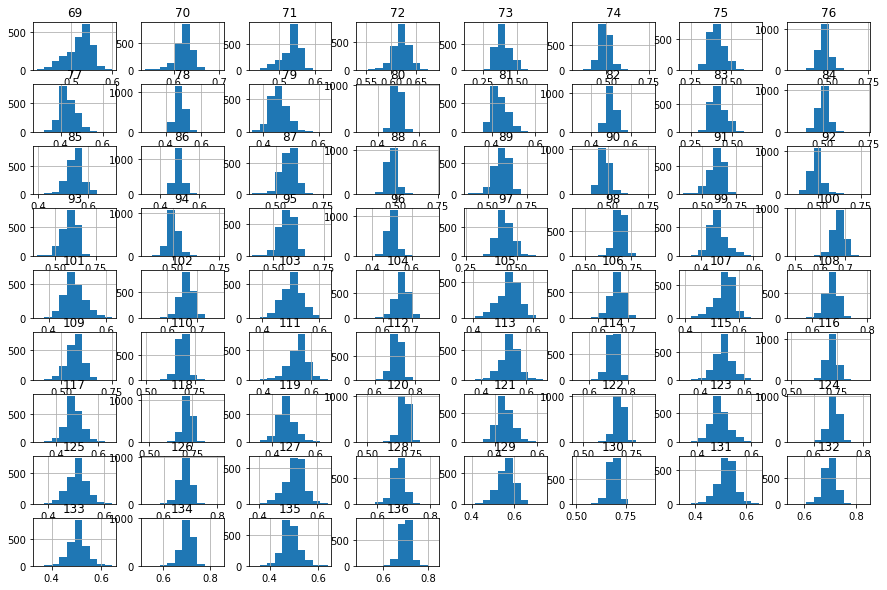

In [ ]:
features_y.hist(figsize = (15,10))

<AxesSubplot:ylabel='Count'>

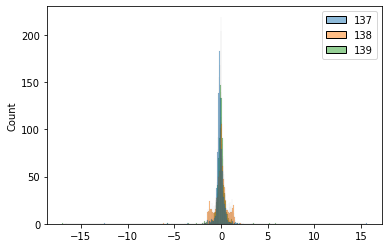

In [ ]:
sns.histplot(labels)

<AxesSubplot:xlabel='138', ylabel='Count'>

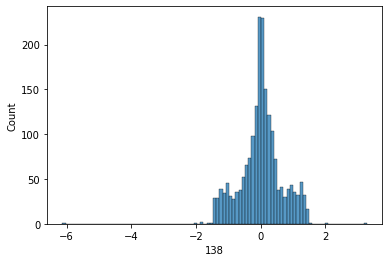

In [ ]:
sns.histplot(yaw)

In [ ]:
# sns.pairplot(data_df[features_x],data_df.loc[138])

### Applying PCA to decrease No. of Features

In [ ]:
pca = PCA()
pca_df = pca.fit_transform(features) 
pca.explained_variance_ratio_

array([3.84485064e-01, 2.39575723e-01, 2.16256669e-01, 6.92289965e-02,
       4.00213934e-02, 1.93750379e-02, 1.07038281e-02, 8.58425828e-03,
       2.94169847e-03, 1.85492618e-03, 1.22946940e-03, 9.53466449e-04,
       8.24533011e-04, 5.10937354e-04, 4.68865563e-04, 3.82868837e-04,
       3.52631502e-04, 2.78125111e-04, 2.41746394e-04, 1.61893843e-04,
       1.51861818e-04, 1.44822942e-04, 1.40060873e-04, 1.21832919e-04,
       1.14345462e-04, 1.05184426e-04, 7.81478935e-05, 6.31622088e-05,
       5.08016509e-05, 4.94218430e-05, 4.66894735e-05, 4.13943082e-05,
       3.95096064e-05, 3.44259060e-05, 3.05767152e-05, 2.93170702e-05,
       2.61067076e-05, 2.29001308e-05, 2.16510241e-05, 2.00221586e-05,
       1.67913481e-05, 1.64773410e-05, 1.51576137e-05, 1.34658267e-05,
       1.26376083e-05, 1.22802314e-05, 1.04541984e-05, 1.01606063e-05,
       9.26985551e-06, 8.27355139e-06, 7.67133977e-06, 7.02281965e-06,
       6.64468276e-06, 6.40405844e-06, 5.56539435e-06, 5.38557818e-06,
      

Text(0, 0.5, 'cumulative explained variance')

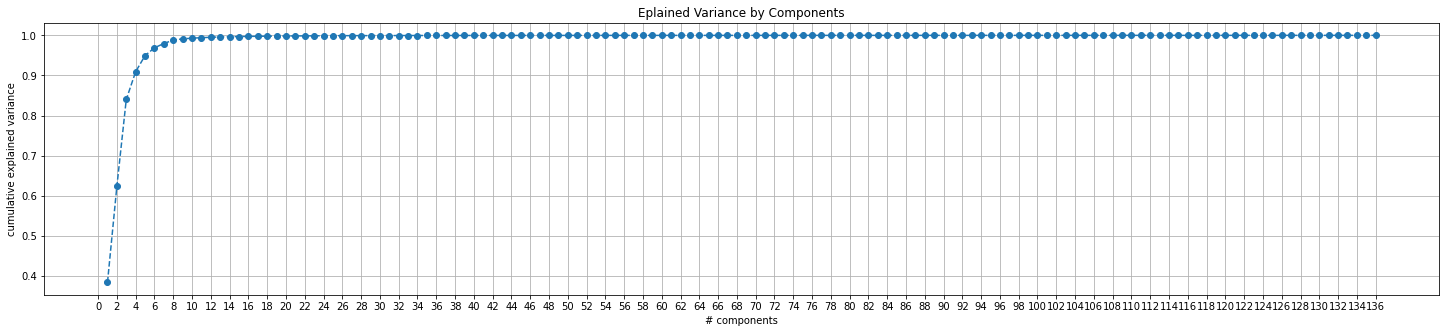

In [ ]:
plt.figure(figsize=(25, 5))
plt.xticks(np.arange(len(features.columns)+1, step=2)) 
plt.plot(range(1,len(features.columns)+1),pca.explained_variance_ratio_.cumsum(),marker = 'o',linestyle = '--')
plt.grid()
plt.title('Eplained Variance by Components')
plt.xlabel('# components')
plt.ylabel('cumulative explained variance')

In [ ]:
pca = PCA(8)
pca_df = pca.fit(features)
_trans = pca.transform(features)

pca_trans_df = pd.DataFrame(data= _trans)
pca_trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       2000 non-null   float64
 1   1       2000 non-null   float64
 2   2       2000 non-null   float64
 3   3       2000 non-null   float64
 4   4       2000 non-null   float64
 5   5       2000 non-null   float64
 6   6       2000 non-null   float64
 7   7       2000 non-null   float64
dtypes: float64(8)
memory usage: 125.1 KB


## Applying Model

#### Spliting data into Training and Testing Sets

In [ ]:
# [pitch, yaw, roll]

# Pitch
X_train_pitch, X_test_pitch, y_train_pitch, y_test_pitch = train_test_split(features, pitch, test_size=0.3, random_state=0)

# Yaw
X_train_yaw, X_test_yaw, y_train_yaw, y_test_yaw = train_test_split(features, yaw, test_size=0.3, random_state=0)

# Roll
X_train_roll, X_test_roll, y_train_roll, y_test_roll = train_test_split(features, roll, test_size=0.3, random_state=0)

#### Baeline Model

Applying Linear Regression Model on all Features without PCA

In [ ]:
lr = LinearRegression()

# Pitch
y_pred_pitch = lr.fit(X_train_pitch, y_train_pitch).predict(X_test_pitch)

# Yaw
y_pred_yaw = lr.fit(X_train_yaw, y_train_yaw).predict(X_test_yaw)

# Roll
y_pred_roll = lr.fit(X_train_roll, y_train_roll).predict(X_test_roll)

In [ ]:
print("Pitch MSE = %f"%(mean_squared_error(y_test_pitch, y_pred_pitch)))

print("Yaw MSE = %f"%(mean_squared_error(y_test_yaw, y_pred_yaw)))

print("Roll MSE = %f"%(mean_squared_error(y_test_roll, y_pred_roll)))

Pitch MSE = 0.232641
Yaw MSE = 0.020241
Roll MSE = 0.337565


### PCA Linear Regression Model

In [ ]:
# [pitch, yaw, roll]

# Pitch
X_train_pitch, X_test_pitch, y_train_pitch, y_test_pitch = train_test_split(pca_trans_df, pitch, test_size=0.3, random_state=0)

# Yaw
X_train_yaw, X_test_yaw, y_train_yaw, y_test_yaw = train_test_split(pca_trans_df, yaw, test_size=0.3, random_state=0)

# Roll
X_train_roll, X_test_roll, y_train_roll, y_test_roll = train_test_split(pca_trans_df, roll, test_size=0.3, random_state=0)

In [ ]:
lr = LinearRegression()

# Pitch
y_pred_pitch = lr.fit(X_train_pitch, y_train_pitch).predict(X_test_pitch)

# Yaw
y_pred_yaw = lr.fit(X_train_yaw, y_train_yaw).predict(X_test_yaw)

# Roll
y_pred_roll = lr.fit(X_train_roll, y_train_roll).predict(X_test_roll)

In [ ]:
print("Linear Regression Mode With PCA :-")

print("Pitch MSE = %f"%(mean_squared_error(y_test_pitch, y_pred_pitch)))

print("Yaw MSE = %f"%(mean_squared_error(y_test_yaw, y_pred_yaw)))

print("Roll MSE = %f"%(mean_squared_error(y_test_roll, y_pred_roll)))

Linear Regression Mode With PCA :-
Pitch MSE = 0.148084
Yaw MSE = 0.014245
Roll MSE = 0.221763


### PCA Lasso(Logistic) Regresion Model

In [ ]:
clf = linear_model.Lasso(alpha=0.1)

# Pitch
y_pred_pitch = clf.fit(X_train_pitch, y_train_pitch).predict(X_test_pitch)

# Yaw
y_pred_yaw = clf.fit(X_train_yaw, y_train_yaw).predict(X_test_yaw)

# Roll
y_pred_roll = clf.fit(X_train_roll, y_train_roll).predict(X_test_roll)

In [ ]:
print("Lasso Linear Regression Mode With PCA :-")

print("Pitch MSE = %f"%(mean_squared_error(y_test_pitch, y_pred_pitch)))

print("Yaw MSE = %f"%(mean_squared_error(y_test_yaw, y_pred_yaw)))

print("Roll MSE = %f"%(mean_squared_error(y_test_roll, y_pred_roll)))

# print("Overall MSE = %f"%(mean()))

Lasso Linear Regression Mode With PCA :-
Pitch MSE = 0.235393
Yaw MSE = 0.114882
Roll MSE = 0.273175


### MultiOutput Regressor

In [ ]:
# pca_trans_df = pca_trans_df.sample(frac=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pca_trans_df, labels, test_size=0.3, random_state=0)

In [ ]:
multiR = MultiOutputRegressor(RandomForestRegressor(max_depth=100 ,random_state=0))
y_pred = multiR.fit(X_train, y_train).predict(X_test)

In [ ]:
print("MultiOutput Regressor/Random Forest Regressor Model With PCA :-")

print("MSE = %f"%(mean_squared_error(y_test, y_pred)))
print("R-2 Score = %f\n"%(r2_score(y_test, y_pred)))

# MultiOutput Regressor/Random Forest Regressor Model With PCA :-
# MSE = 0.058624
# R-2 Score = 0.770275

MultiOutput Regressor/Random Forest Regressor Model With PCA :-
MSE = 0.322769
R-2 Score = 0.371748



In [ ]:
roll_df = pd.DataFrame(roll)
pitch_df = pd.DataFrame(pitch)
yaw_df = pd.DataFrame(yaw)

In [ ]:
poly = PolynomialFeatures(degree=1)
poly_features = poly.fit_transform(features)
poly_roll = poly.fit_transform(roll_df)
poly_pitch = poly.fit_transform(pitch_df)
poly_yaw = poly.fit_transform(yaw_df)

In [ ]:
# Model
forest_model = RandomForestRegressor(max_depth=20, random_state=0)

# Roll
y_pred_roll = forest_model.fit(X_train_roll, y_train_roll).predict(X_test_roll)

print("Random Forest Regressor Model for Roll :-")
print("Roll MSE = %f"%(mean_squared_error(y_test_roll, y_pred_roll)))
print("Accourcy = %f"%(forest_model.score(X_test_roll,y_test_roll)))
print("R-2 Score = %f\n"%(r2_score(y_test_roll, y_pred_roll)))

Random Forest Regressor Model for Roll :-
Roll MSE = 0.094605
Accourcy = 0.869071
R-2 Score = 0.869071



In [ ]:
bagging_model = BaggingRegressor(base_estimator=ExtraTreesRegressor(),n_estimators=10, random_state=0)

# Roll
X_train_roll, X_test_roll, y_train_roll, y_test_roll = train_test_split(poly_features, roll, test_size=0.3, random_state=0)
y_pred_roll = bagging_model.fit(X_train_roll, y_train_roll).predict(X_test_roll)

# Results
print("Bagging/Extra Trees Regressor Model for Roll :-")
print("Roll MSE = %f"%(mean_squared_error(y_test_roll, y_pred_roll)))
print("Accourcy = %f"%(bagging_model.score(X_test_roll,y_test_roll)))
print("R-2 Score = %f\n"%(r2_score(y_test_roll, y_pred_roll)))

Bagging/Extra Trees Regressor Model for Roll :-
Roll MSE = 0.123931
Accourcy = 0.828484
R-2 Score = 0.828484



In [ ]:

gradient_boosting = GradientBoostingRegressor(random_state=0)
# Pitch
X_train_pitch, X_test_pitch, y_train_pitch, y_test_pitch = train_test_split(pca_trans_df, pitch, test_size=0.3, random_state=0)
y_pred_pitch = gradient_boosting.fit(X_train_pitch, y_train_pitch).predict(X_test_pitch)

print("Bagging/Extra Trees Regressor Model for Roll :-")
print("Roll MSE = %f"%(mean_squared_error(y_test_pitch, y_pred_pitch)))
print("Accourcy = %f"%(gradient_boosting.score(X_test_pitch,y_test_pitch)))
print("R-2 Score = %f\n"%(r2_score(y_test_pitch, y_pred_pitch)))

Bagging/Extra Trees Regressor Model for Roll :-
Roll MSE = 0.782003
Accourcy = -0.685264
R-2 Score = -0.685264



In [ ]:

# gradient_boosting = GradientBoostingRegressor(random_state=0)
# Pitch
X_train_pitch, X_test_pitch, y_train_pitch, y_test_pitch = train_test_split(pca_trans_df, pitch, test_size=0.3, random_state=0)
y_pred_pitch = svr_model.fit(X_train_pitch, y_train_pitch).predict(X_test_pitch)

print("Bagging/Extra Trees Regressor Model for Roll :-")
print("Roll MSE = %f"%(mean_squared_error(y_test_pitch, y_pred_pitch)))
print("Accourcy = %f"%(svr_model.score(X_test_pitch,y_test_pitch)))
print("R-2 Score = %f\n"%(r2_score(y_test_pitch, y_pred_pitch)))

Bagging/Extra Trees Regressor Model for Roll :-
Roll MSE = 0.340008
Accourcy = 0.267262
R-2 Score = 0.267262



In [ ]:
svr_model = BaggingRegressor(base_estimator=GradientBoostingRegressor(),n_estimators=10, random_state=0)
gradient_boosting = GradientBoostingRegressor(random_state=0)
# Pitch
X_train_pitch, X_test_pitch, y_train_pitch, y_test_pitch = train_test_split(poly_features, pitch, test_size=0.3, random_state=0)
y_pred_pitch = svr_model.fit(X_train_pitch, y_train_pitch).predict(X_test_pitch)

print("Bagging/Extra Trees Regressor Model for Roll :-")
print("Roll MSE = %f"%(mean_squared_error(y_test_pitch, y_pred_pitch)))
print("Accourcy = %f"%(svr_model.score(X_test_pitch,y_test_pitch)))
print("R-2 Score = %f\n"%(r2_score(y_test_pitch, y_pred_pitch)))



Bagging/Extra Trees Regressor Model for Roll :-
Roll MSE = 0.891133
Accourcy = -0.920444
R-2 Score = -0.920444



In [ ]:
# Pitch
y_pred_pitch = voting_model.fit(X_train_pitch, y_train_pitch).predict(X_test_pitch)

# Yaw
X_train_yaw, X_test_yaw, y_train_yaw, y_test_yaw = train_test_split(features, yaw, test_size=0.3, random_state=0)


In [ ]:
df_ = pd.read_csv('datafile.csv')
df_.head()

,x,y,z,yaw,pitch,roll,img
0,33.0,25.0,34.0,1.044306,-22.874239,4.908886,image00002
1,55.0,41.0,38.0,68.155240,26.932743,17.243670,image00004
2,49.0,29.0,28.0,50.485413,-10.579652,-13.570645,image00006
3,38.0,29.0,25.0,17.143373,-10.048455,-21.392782,image00008
4,55.0,16.0,13.0,68.640550,-50.544582,-59.207973,image00010


In [ ]:
features_ = df_[['x','y','z']]
labels_ = df_[['yaw','pitch','roll']]

In [ ]:
# Pitch
X_train_yaw, X_test_yaw, y_train_yaw, y_test_yaw = train_test_split(features_, labels_['pitch'], test_size=0.3, random_state=0)

# Yaw
X_train_yaw, X_test_yaw, y_train_yaw, y_test_yaw = train_test_split(features_, labels_['yaw'], test_size=0.3, random_state=0)

# Roll
X_train_roll, X_test_roll, y_train_roll, y_test_roll = train_test_split(features_, labels_['roll'], test_size=0.3, random_state=0)

In [ ]:
lr = LinearRegression()

# Pitch
y_pred_pitch = lr.fit(X_train_pitch, y_train_pitch).predict(X_test_pitch)

# Yaw
y_pred_yaw = lr.fit(X_train_yaw, y_train_yaw).predict(X_test_yaw)

# Roll
y_pred_roll = lr.fit(X_train_roll, y_train_roll).predict(X_test_roll)

In [ ]:
print("Pitch MSE = %f"%(mean_squared_error(y_test_pitch, y_pred_pitch)))

print("Yaw MSE = %f"%(mean_squared_error(y_test_yaw, y_pred_yaw)))

print("Roll MSE = %f"%(mean_squared_error(y_test_roll, y_pred_roll)))

Pitch MSE = 0.235380
Yaw MSE = 2.425698
Roll MSE = 168.019143
